# MRS out-of-band radiation
In this notebook we derive the MRS out-of-band radiation from FM MRS_RAD_08 measurements. These are extended source measurements of an 800K blackbody source, observed through a long-wave-pass filter and a short-wave-pass filter.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

Below we show the MRS detector images taken with the long-wave-pass filter (LWP) and the short-wave-pass (SWP) filter.

In [2]:
# import modules
import funcs
import mrsobs

from numpy import (genfromtxt,nonzero,isnan)
import scipy.interpolate as scp_interpolate
from scipy.signal import savgol_filter
from astropy.io import fits
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [3]:
# MRS spectral bands and detector pixel dimensions
bands    = ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]

In [4]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'
MRSWaveCalDir = workDir+"MRSWaveCal/" 
MTSDir        = workDir+'MRSFluxCal/MIRI_CDP6MRSFluxCal/MtsIrradiance/'

In [5]:
# Populate dictionaries with maps of SCI_pix [DN/sec]
# SCI_pix is the average slope of the BB measurement.
# BKG_pix is the average slope of the background measurement.
# Note that for both filter measurements there is only one background measurement.

LWP_SCI_pixMap,SWP_SCI_pixMap,EXT_SCI_pixMap,EXT_BKG_pixMap = {},{},{},{}
FILTER_BKG_pixMap,EXT_BKG_pixMap = {},{}
LWP_CAL_pixMap,SWP_CAL_pixMap,EXT_CAL_pixMap = {},{},{}
for band in bands:
    LWP_SCI_pixMap[band],FILTER_BKG_pixMap[band] = mrsobs.FM_MTS_800K_BB_MRS_RAD_08(lvl2path,band,wp_filter='LWP',output='img')
    SWP_SCI_pixMap[band],ignore                  = mrsobs.FM_MTS_800K_BB_MRS_RAD_08(lvl2path,band,wp_filter='SWP',output='img')
    EXT_SCI_pixMap[band],EXT_BKG_pixMap[band]    = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K',output='img')
    LWP_CAL_pixMap[band] = LWP_SCI_pixMap[band]-FILTER_BKG_pixMap[band]
    SWP_CAL_pixMap[band] = SWP_SCI_pixMap[band]-FILTER_BKG_pixMap[band]
    EXT_CAL_pixMap[band] = EXT_SCI_pixMap[band]-EXT_BKG_pixMap[band]

In [6]:
# Compute the LWP and SWP filter transmission by dividing the respective signals by the reference 800K BB extended source observations
LWP_TR_pixMap,SWP_TR_pixMap = {},{}
for band in bands:
    LWP_TR_pixMap[band] = LWP_CAL_pixMap[band]/EXT_CAL_pixMap[band]
    SWP_TR_pixMap[band] = SWP_CAL_pixMap[band]/EXT_CAL_pixMap[band]

<IPython.core.display.Javascript object>


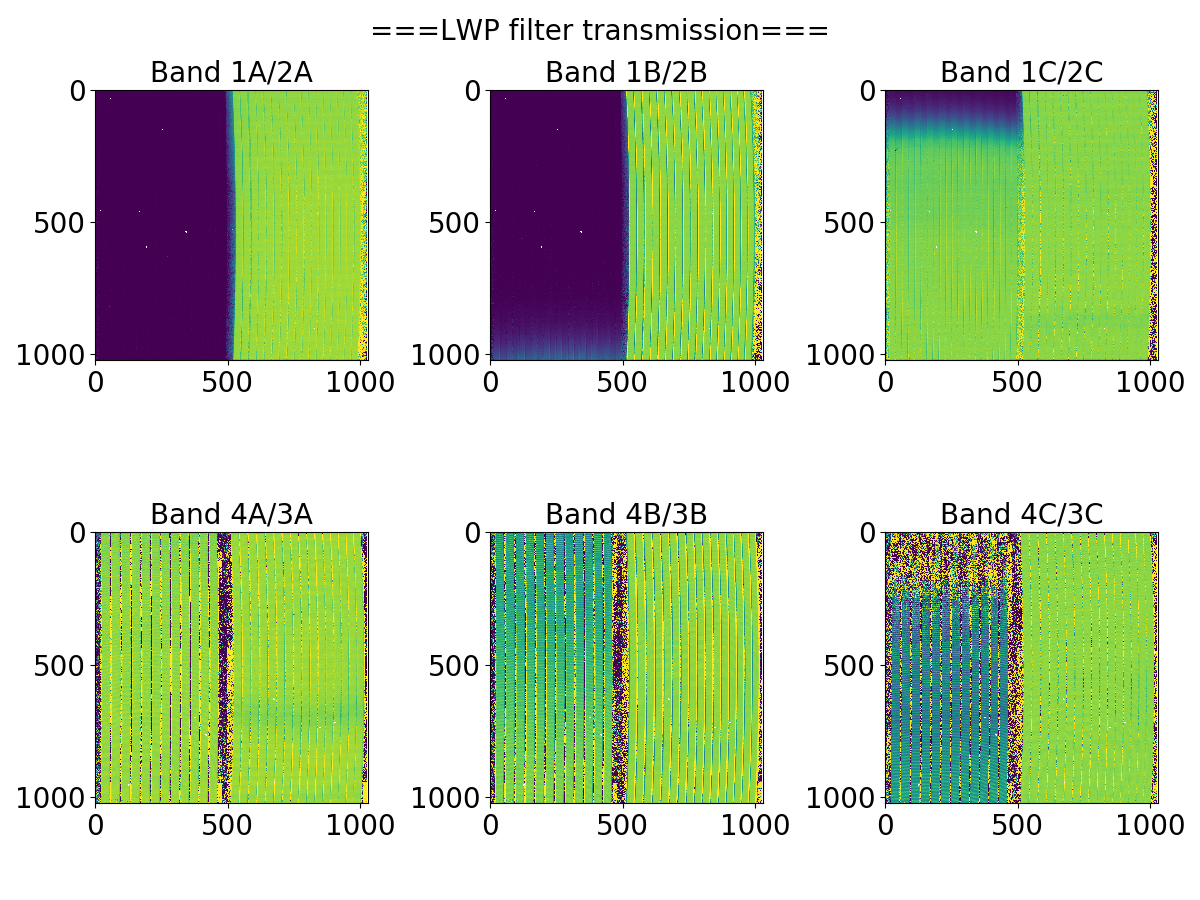

<IPython.core.display.Javascript object>


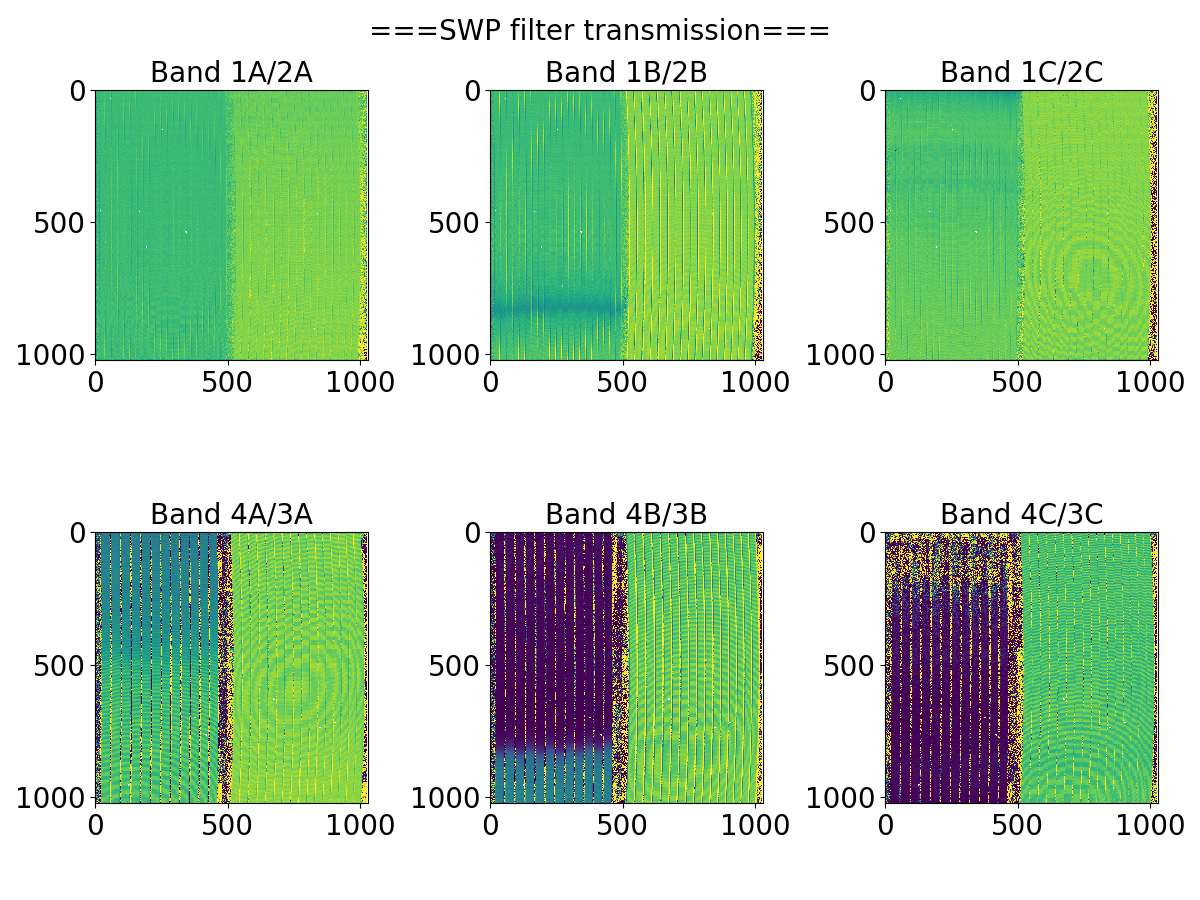

In [6]:
fig,axs = plt.subplots(2,3,figsize=(12,9))
axs[0,0].imshow(LWP_TR_pixMap['1A'],vmin=0,vmax=1.1)
axs[0,0].set_title('Band 1A/2A')
axs[0,1].imshow(LWP_TR_pixMap['1B'],vmin=0,vmax=1.1)
axs[0,1].set_title('Band 1B/2B')
axs[0,2].imshow(LWP_TR_pixMap['1C'],vmin=0,vmax=1.1)
axs[0,2].set_title('Band 1C/2C')
axs[1,0].imshow(LWP_TR_pixMap['3A'],vmin=0,vmax=1.1)
axs[1,0].set_title('Band 4A/3A')
axs[1,1].imshow(LWP_TR_pixMap['3B'],vmin=0,vmax=1.1)
axs[1,1].set_title('Band 4B/3B')
axs[1,2].imshow(LWP_TR_pixMap['3C'],vmin=0,vmax=1.1)
axs[1,2].set_title('Band 4C/3C')
plt.suptitle('===LWP filter transmission===',fontsize=20)
plt.tight_layout()

fig,axs = plt.subplots(2,3,figsize=(12,9))
axs[0,0].imshow(SWP_TR_pixMap['1A'],vmin=0,vmax=1.1)
axs[0,0].set_title('Band 1A/2A')
axs[0,1].imshow(SWP_TR_pixMap['1B'],vmin=0,vmax=1.1)
axs[0,1].set_title('Band 1B/2B')
axs[0,2].imshow(SWP_TR_pixMap['1C'],vmin=0,vmax=1.1)
axs[0,2].set_title('Band 1C/2C')
axs[1,0].imshow(SWP_TR_pixMap['3A'],vmin=0,vmax=1.1)
axs[1,0].set_title('Band 4A/3A')
axs[1,1].imshow(SWP_TR_pixMap['3B'],vmin=0,vmax=1.1)
axs[1,1].set_title('Band 4B/3B')
axs[1,2].imshow(SWP_TR_pixMap['3C'],vmin=0,vmax=1.1)
axs[1,2].set_title('Band 4C/3C')
plt.suptitle('===SWP filter transmission===',fontsize=20)
plt.tight_layout()

By following a pixel trace in a single slice, in every MRS spectral band, a 1D spectrum can be extracted. This is shown below. The raw LWP and SWP signal are shown, along with the corresponding background measurements.

<IPython.core.display.Javascript object>


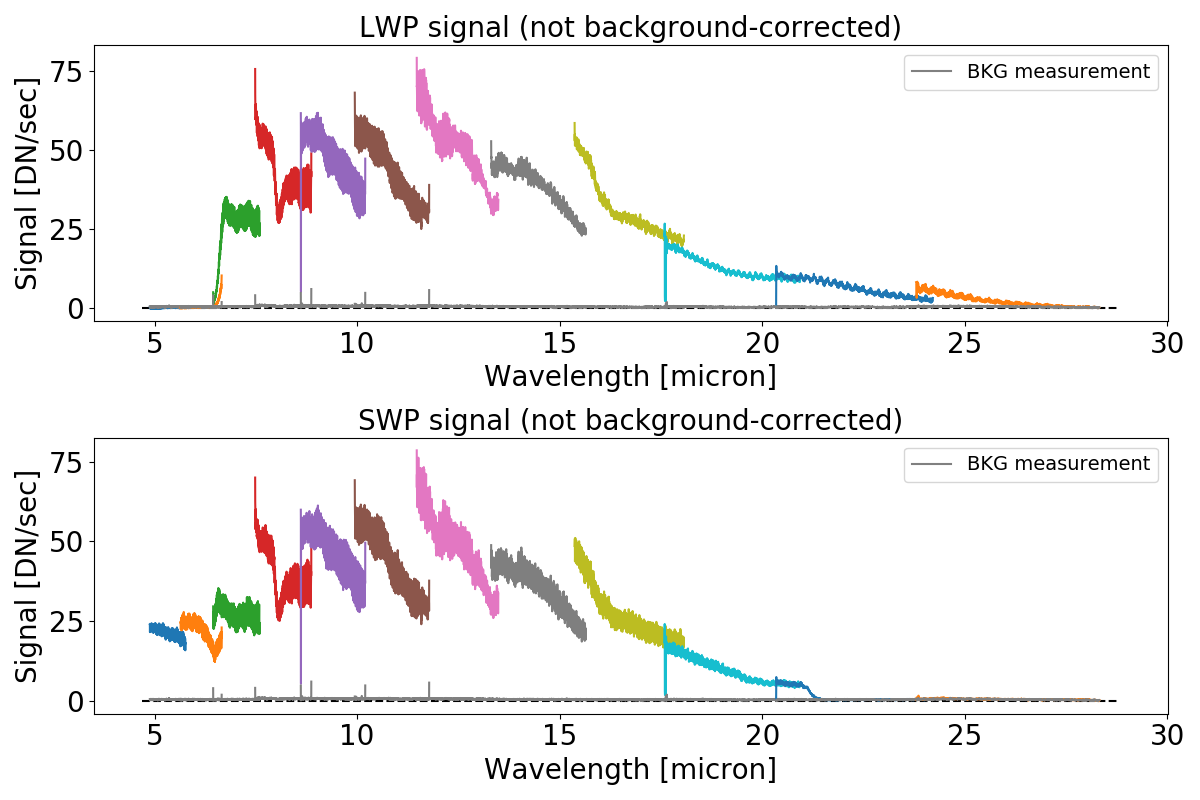

In [7]:
fig,axs = plt.subplots(2,1,figsize=(12,8))
axs[0].set_title('LWP signal (not background-corrected)')
axs[1].set_title('SWP signal (not background-corrected)')
for band in bands:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    lambdaMap = d2cMaps['lambdaMap']
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
    axs[0].plot(lambdaMap[ypos,xpos],LWP_SCI_pixMap[band][ypos,xpos])
    axs[0].plot(lambdaMap[ypos,xpos],FILTER_BKG_pixMap[band][ypos,xpos],'gray')
    axs[1].plot(lambdaMap[ypos,xpos],SWP_SCI_pixMap[band][ypos,xpos])
    axs[1].plot(lambdaMap[ypos,xpos],FILTER_BKG_pixMap[band][ypos,xpos],'gray')
for plot in range(2):
    axs[plot].hlines(0,4.7,28.8,'k',linestyle='dashed')
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Signal [DN/sec]')
    legend_elements = [Line2D([0],[0],color='gray',label='BKG measurement')]
    axs[plot].legend(handles=legend_elements,loc='upper right')
plt.tight_layout()

### Remarks:
* The background signal is higher than the LWP signal up to the transmission cut-off in band 1B.
* The background signal matches the SWP signal after the transmission cut-off in band 4B.

Let us subtract the background from the raw signal.

<IPython.core.display.Javascript object>


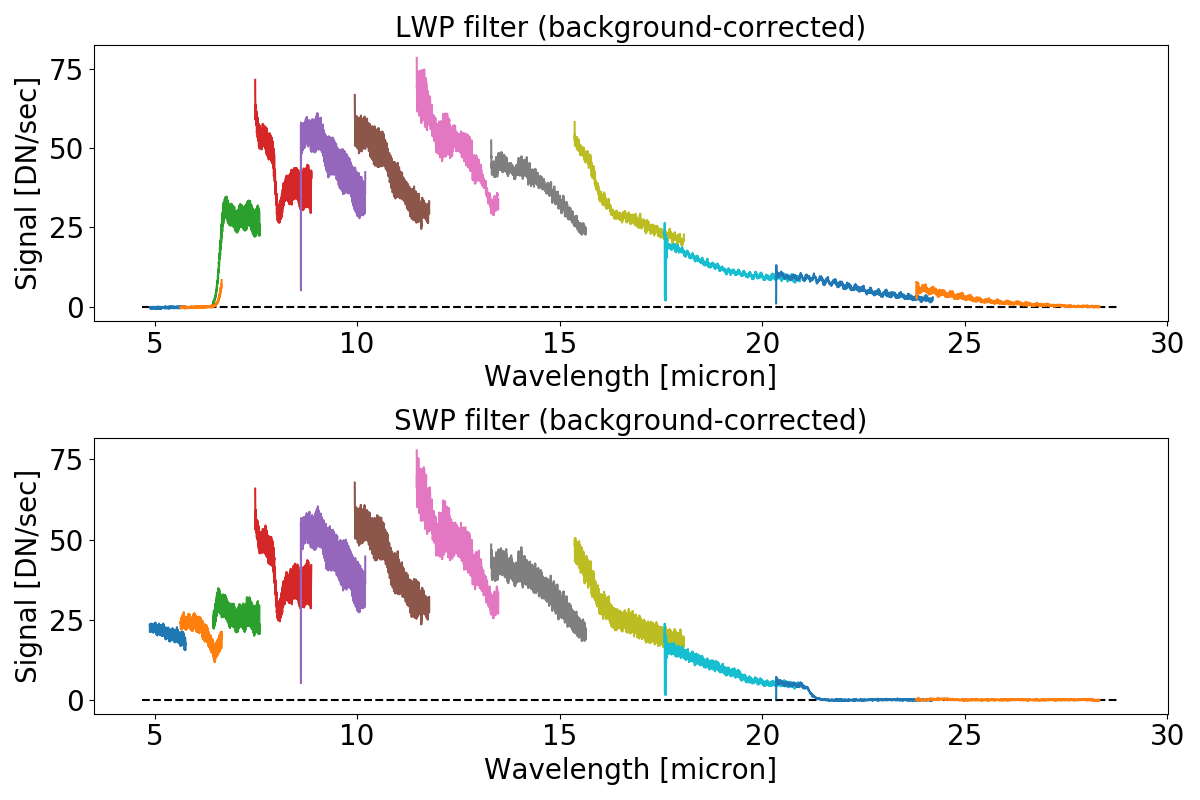

In [8]:
fig,axs = plt.subplots(2,1,figsize=(12,8))
axs[0].set_title('LWP filter (background-corrected)')
axs[1].set_title('SWP filter (background-corrected)')
for band in bands:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    lambdaMap = d2cMaps['lambdaMap']
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
    axs[0].plot(lambdaMap[ypos,xpos],LWP_CAL_pixMap[band][ypos,xpos])
    axs[1].plot(lambdaMap[ypos,xpos],SWP_CAL_pixMap[band][ypos,xpos])
for plot in range(2):
    axs[plot].hlines(0,4.7,28.8,'k',linestyle='dashed')
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Signal [DN/sec]')
plt.tight_layout()

### Remarks:
* The absolute signal levels of the SWP and LWP spectra is similar. This is expected since the two filters have similar transmission spectra.  
  
Let's overplot the background-corrected LWP and SWP signals and examine the ratio of the two.

<IPython.core.display.Javascript object>


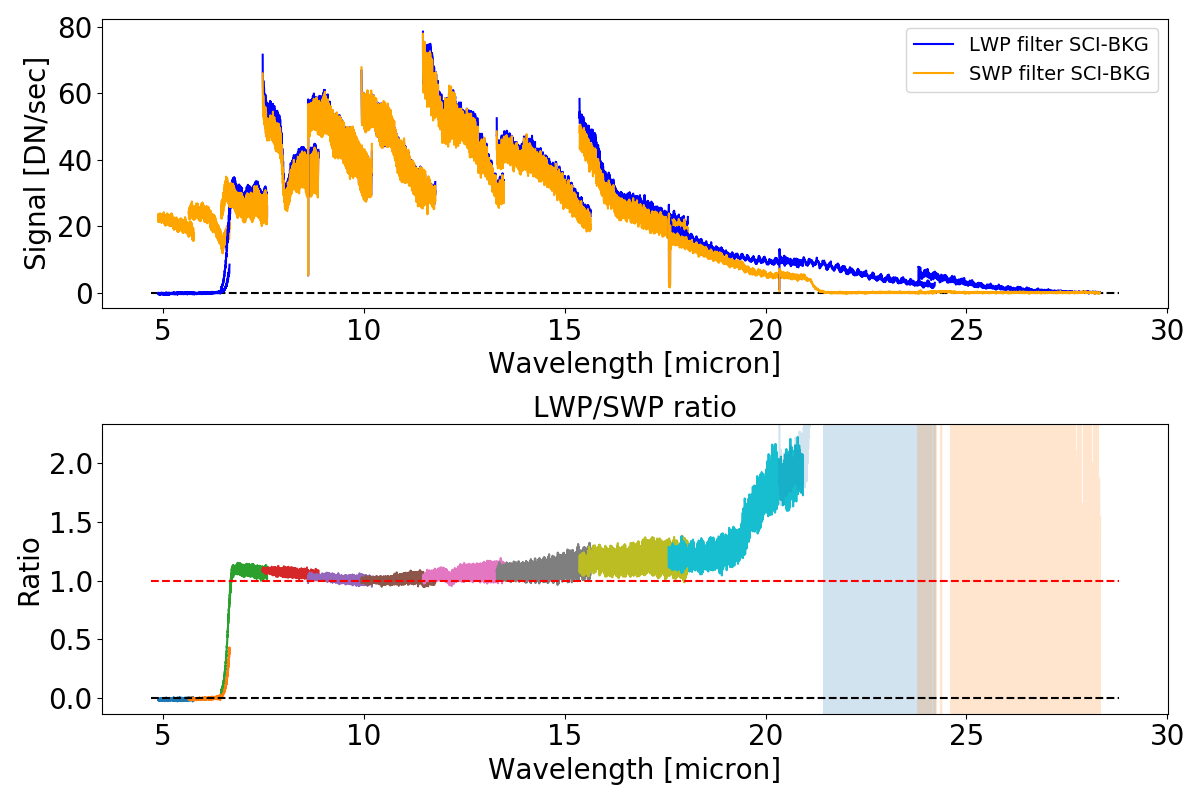

In [9]:
fig,axs = plt.subplots(2,1,figsize=(12,8))
for band in bands:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    lambdaMap = d2cMaps['lambdaMap']
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
    axs[0].plot(lambdaMap[ypos,xpos],LWP_CAL_pixMap[band][ypos,xpos],'b')
    axs[0].plot(lambdaMap[ypos,xpos],SWP_CAL_pixMap[band][ypos,xpos],'orange')
    if band in ['4B','4C']:
        axs[1].plot(lambdaMap[ypos,xpos],LWP_CAL_pixMap[band][ypos,xpos]/SWP_CAL_pixMap[band][ypos,xpos],alpha=0.2,zorder=0)
    else:
        axs[1].plot(lambdaMap[ypos,xpos],LWP_CAL_pixMap[band][ypos,xpos]/SWP_CAL_pixMap[band][ypos,xpos],zorder=0)
legend_elements = [Line2D([0],[0],color='b',label='LWP filter SCI-BKG'),Line2D([0],[0],color='orange',label='SWP filter SCI-BKG')]
axs[0].legend(handles=legend_elements,loc='upper right')
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].hlines(1,4.7,28.8,'r',linestyle='dashed',zorder=1)
axs[1].set_ylim(-0.135,2.33)
for plot in range(2):
    axs[plot].hlines(0,4.7,28.8,'k',linestyle='dashed')
    axs[plot].set_xlabel('Wavelength [micron]')
axs[1].set_ylabel('Ratio')
axs[1].set_title('LWP/SWP ratio')
plt.tight_layout()

### Remarks:
* The fringe residual is least in band 2C (6% peak-to-peak).
* The difference in the absolute signal of the two filters can be seen as the ratio of the two signals being non-unity.
* Note that since the SWP signal is zero beyond 21 micron, the ratio blows up the those wavelengths.
  
Let's overplot the filter signals, the reference extended source measurements, and all the background measurements.

<IPython.core.display.Javascript object>


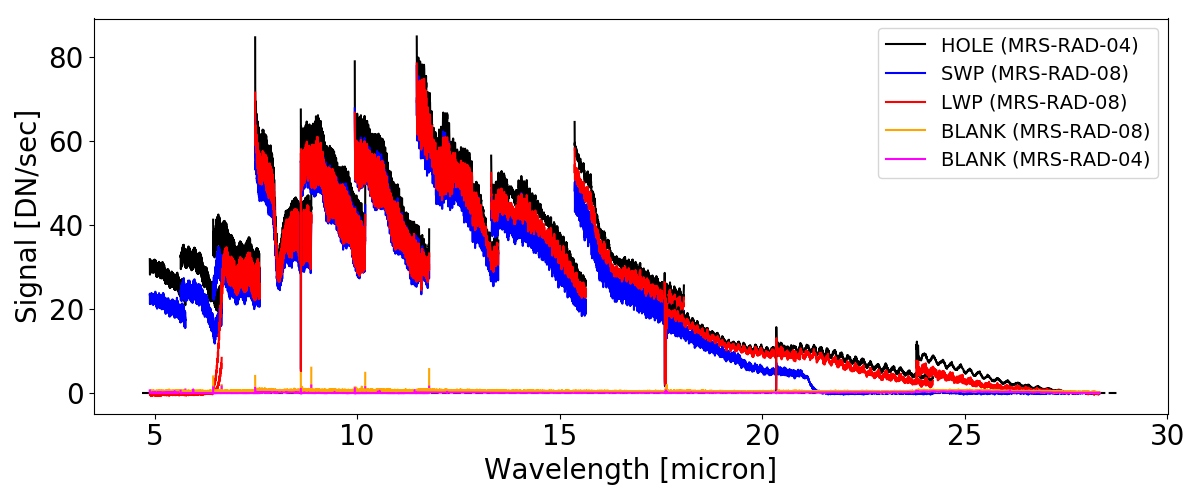

In [7]:
plt.figure(figsize=(12,5))
for band in bands:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    lambdaMap = d2cMaps['lambdaMap']
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
    plt.plot(lambdaMap[ypos,xpos],EXT_CAL_pixMap[band][ypos,xpos],'k')
    plt.plot(lambdaMap[ypos,xpos],SWP_CAL_pixMap[band][ypos,xpos],'b')
    plt.plot(lambdaMap[ypos,xpos],LWP_CAL_pixMap[band][ypos,xpos],'r')
    plt.plot(lambdaMap[ypos,xpos],FILTER_BKG_pixMap[band][ypos,xpos],'orange')
    plt.plot(lambdaMap[ypos,xpos],EXT_BKG_pixMap[band][ypos,xpos],'magenta')
plt.hlines(0,4.7,28.8,'k',linestyle='dashed')
legend_elements = [Line2D([0],[0],color='k',label='HOLE (MRS-RAD-04)'),
                   Line2D([0],[0],color='b',label='SWP (MRS-RAD-08)'),
                   Line2D([0],[0],color='r',label='LWP (MRS-RAD-08)'),
                   Line2D([0],[0],color='orange',label='BLANK (MRS-RAD-08)'),
                   Line2D([0],[0],color='magenta',label='BLANK (MRS-RAD-04)')]
plt.legend(handles=legend_elements,loc='upper right')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

### Remarks:
* The background measurement of the MRS-RAD-04 data is appreciably higher/noisier than the MRS-RAD-08 background measurement. This is due to the different read-out parameters used in the two tests. This discrepancy results in a higher uncertainty in the comparisons that are to follow.  
  
Let's compare the ratio of LWP/HOLE and SWP/HOLE to the filter transmissions derived using a FTS at RAL.

In [11]:
# Read the measured transmission curves from the dat files
# first colum is wavelength [micrometer]
# second and third columns are room temperature transmissions
# fourth column is 35K transmission
LWPwvnr,LWPtransm = genfromtxt(MRSWaveCalDir + "lwp_filter.txt", skip_header = 15, skip_footer=1, usecols=(0,3), delimiter = '',unpack='True')
LWPwave = 10000./LWPwvnr
LWPtransm = LWPtransm/100. # convert percentage to decimal

SWPwvnr,SWPtransm = genfromtxt(MRSWaveCalDir + "swp_filter.txt", skip_header = 15, skip_footer=1, usecols=(0,3), delimiter = '',unpack='True')
SWPwave = 10000./SWPwvnr
SWPtransm = SWPtransm/100. # convert percentage to decimal

<IPython.core.display.Javascript object>


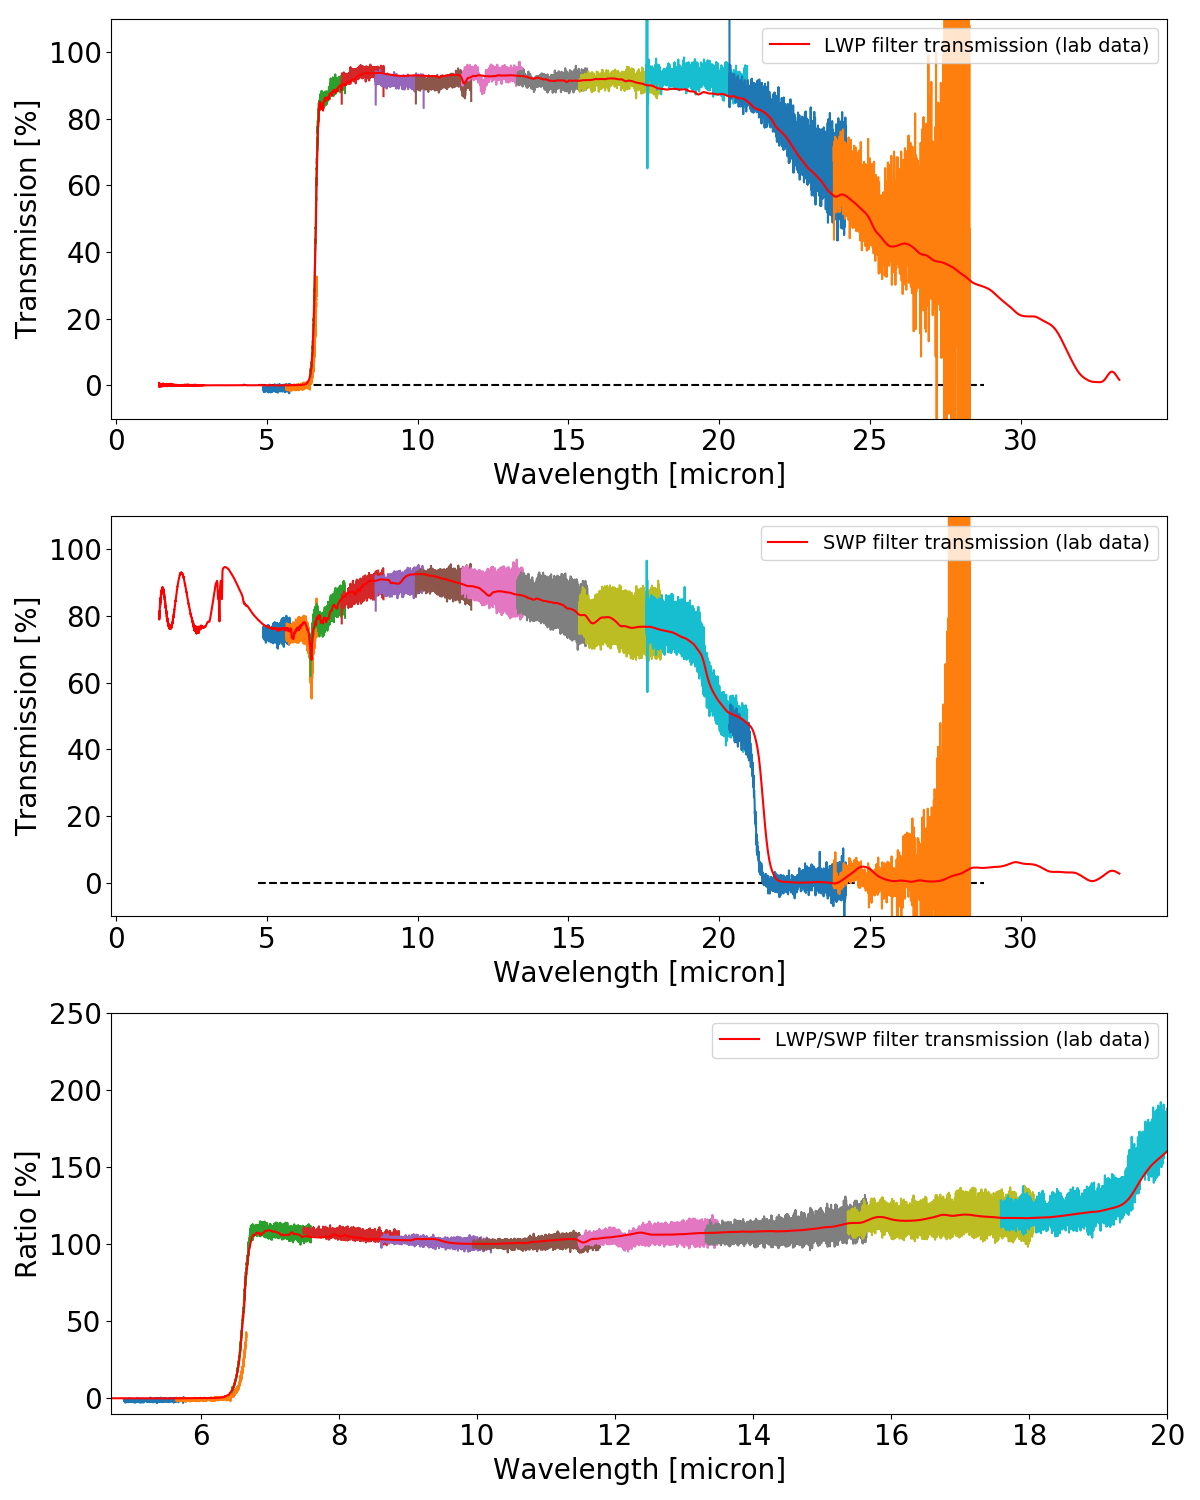

In [12]:
fig,axs = plt.subplots(3,1,figsize=(12,15))
for band in bands:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    lambdaMap = d2cMaps['lambdaMap']
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
    axs[0].plot(lambdaMap[ypos,xpos],(LWP_CAL_pixMap[band][ypos,xpos]/EXT_CAL_pixMap[band][ypos,xpos])*100. )
    axs[1].plot(lambdaMap[ypos,xpos],(SWP_CAL_pixMap[band][ypos,xpos]/EXT_CAL_pixMap[band][ypos,xpos])*100. )
    axs[2].plot(lambdaMap[ypos,xpos],(LWP_CAL_pixMap[band][ypos,xpos]/SWP_CAL_pixMap[band][ypos,xpos])*100. )
axs[0].plot(LWPwave,LWPtransm*100.,'r',label='LWP filter transmission (lab data)')
axs[1].plot(SWPwave,SWPtransm*100.,'r',label='SWP filter transmission (lab data)')
axs[2].plot(SWPwave,(LWPtransm/SWPtransm)*100.,'r',label='LWP/SWP filter transmission (lab data)')
axs[2].set_xlim(4.7,20)
axs[2].set_ylim(-10,250)
for plot in range(2):
    axs[plot].hlines(0,4.7,28.8,'k',linestyle='dashed')
    axs[plot].set_ylim(-10,110)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Transmission [%]')
    axs[plot].legend(loc='upper right')
axs[2].set_xlabel('Wavelength [micron]')
axs[2].set_ylabel('Ratio [%]')
axs[2].legend(loc='upper right')
plt.tight_layout()

### Remarks:
* There is reasonable agreement between the MRS-determined filter transmissions and the lab-determined transmissions.
* There is an interesting offset in wavelength in band 4B of the SWP filter transmission comparison plot.

Let's plot the following differences:
1. the LWP/HOLE MRS-determined transmission minus the LWP lab-determined transmission.
2. the SWP/HOLE MRS-determined transmission minus the SWP lab-determined transmission.
3. the LWP/SWP MRS-determined ratio minus the lab-determined ratio.

<IPython.core.display.Javascript object>


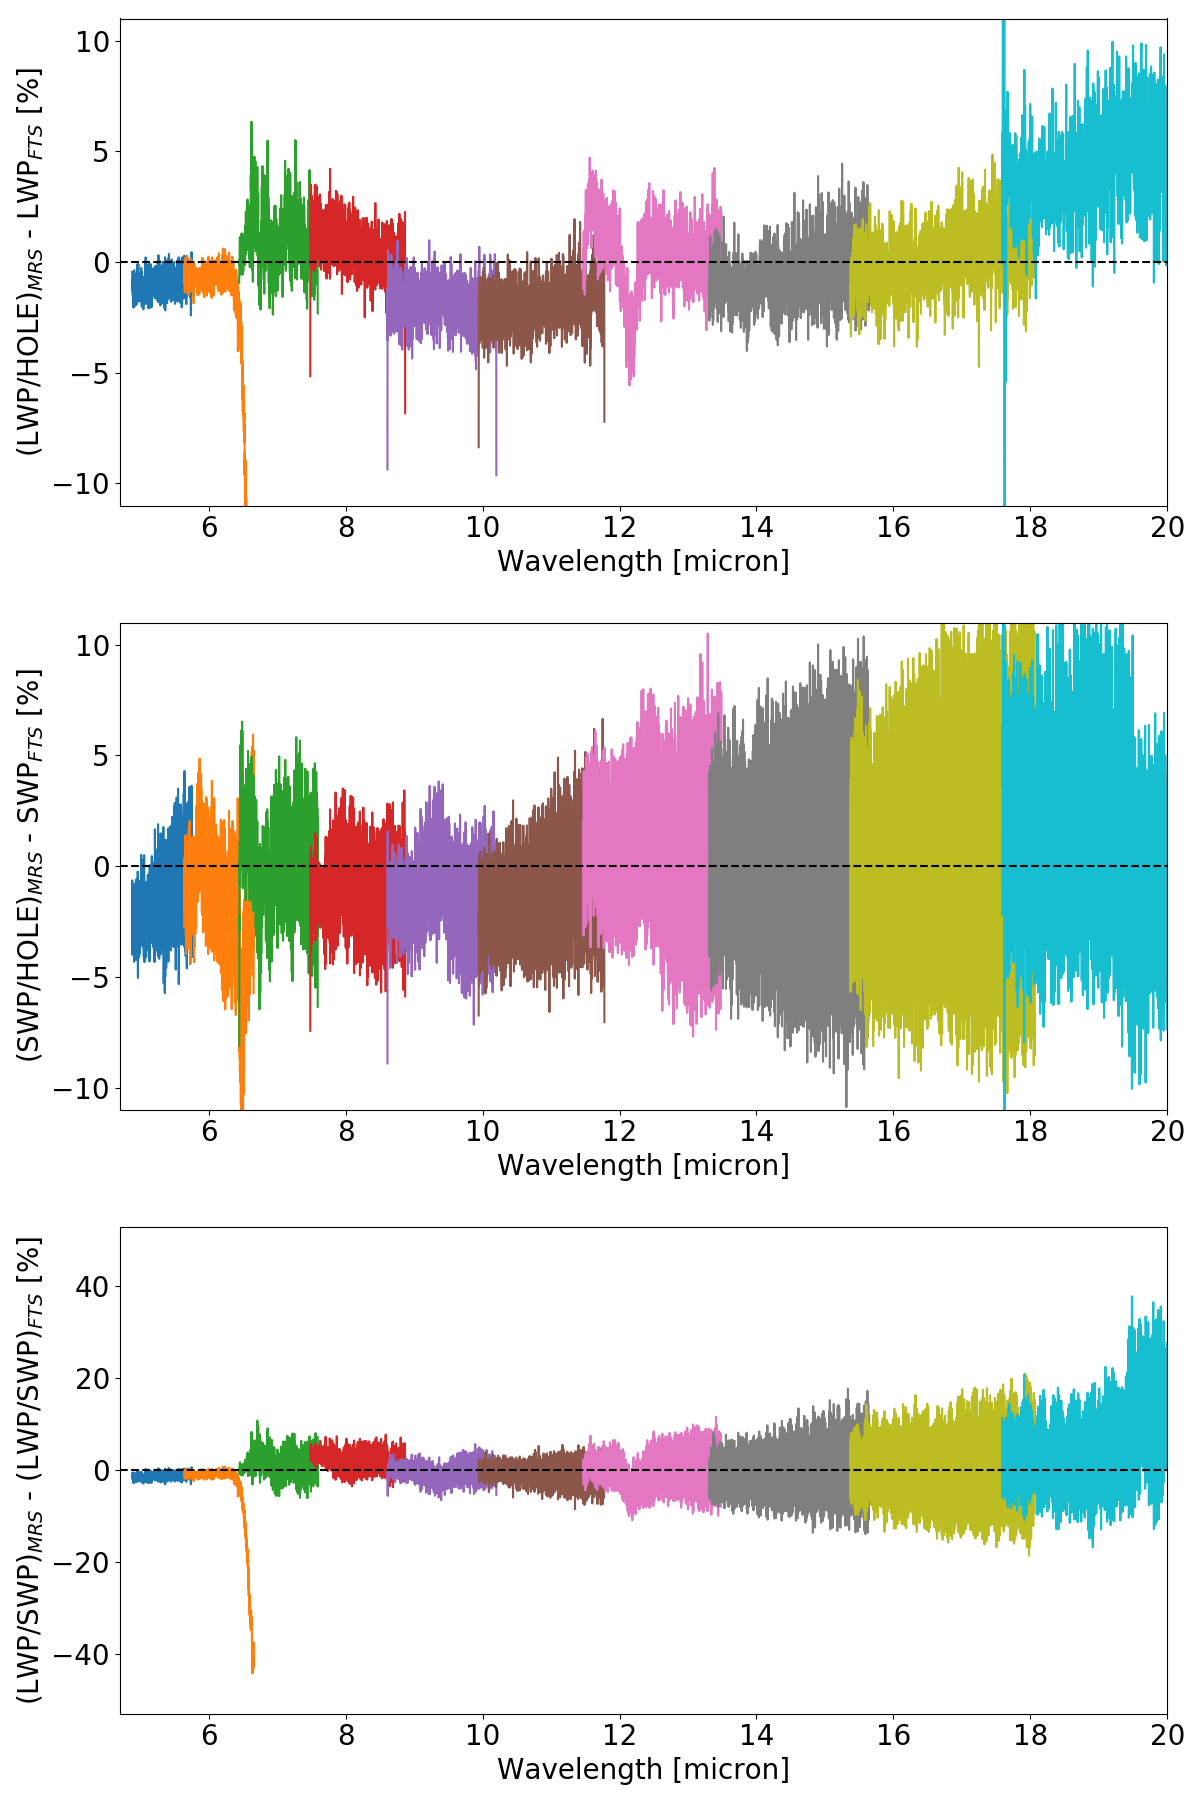

In [13]:
lab_wavl  = SWPwave.copy()
interp_lab_lwp = scp_interpolate.interp1d(lab_wavl,LWPtransm)
interp_lab_swp = scp_interpolate.interp1d(lab_wavl,SWPtransm)
lab_ratio = LWPtransm/SWPtransm
interp_lab_ratio = scp_interpolate.interp1d(lab_wavl,lab_ratio)

fig,axs = plt.subplots(3,1,figsize=(12,18))
for band in bands:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    lambdaMap = d2cMaps['lambdaMap']
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
    sel = nonzero(lambdaMap[ypos,xpos])
    axs[0].plot(lambdaMap[ypos,xpos][sel],((LWP_CAL_pixMap[band][ypos,xpos]/EXT_CAL_pixMap[band][ypos,xpos])[sel] - interp_lab_lwp(lambdaMap[ypos,xpos][sel]))*100.,zorder=0)
    axs[1].plot(lambdaMap[ypos,xpos][sel],((SWP_CAL_pixMap[band][ypos,xpos]/EXT_CAL_pixMap[band][ypos,xpos])[sel] - interp_lab_swp(lambdaMap[ypos,xpos][sel]))*100.,zorder=0)
    axs[2].plot(lambdaMap[ypos,xpos][sel],((LWP_CAL_pixMap[band][ypos,xpos]/SWP_CAL_pixMap[band][ypos,xpos])[sel] - interp_lab_ratio(lambdaMap[ypos,xpos][sel]))*100.,zorder=0)
for plot in range(3):
    axs[plot].hlines(0,4.7,28.8,'k',linestyle='dashed',zorder=1)
    axs[plot].set_xlim(4.7,20)
    axs[plot].set_xlabel('Wavelength [micron]')
axs[0].set_ylim(-11,11)
axs[1].set_ylim(-11,11)
axs[2].set_ylim(-53,53)
axs[0].set_ylabel(r'(LWP/HOLE)$_{MRS}$ - LWP$_{FTS}$ [%]')
axs[1].set_ylabel(r'(SWP/HOLE)$_{MRS}$ - SWP$_{FTS}$ [%]')
axs[2].set_ylabel(r'(LWP/SWP)$_{MRS}$ - (LWP/SWP)$_{FTS}$ [%]')
plt.tight_layout()

### Remarks:
* As mentioned before the difference in the read-out parameters between the LWP/SWP observations and the HOLE observations introduces noise into the data. Furthermore noise is introduced by systematics related to the calibration of the data.  
  
To alleviate the effect of noise on our conclusions, the data are smoothed using a noise filter (Savitzky-Golay).

<IPython.core.display.Javascript object>


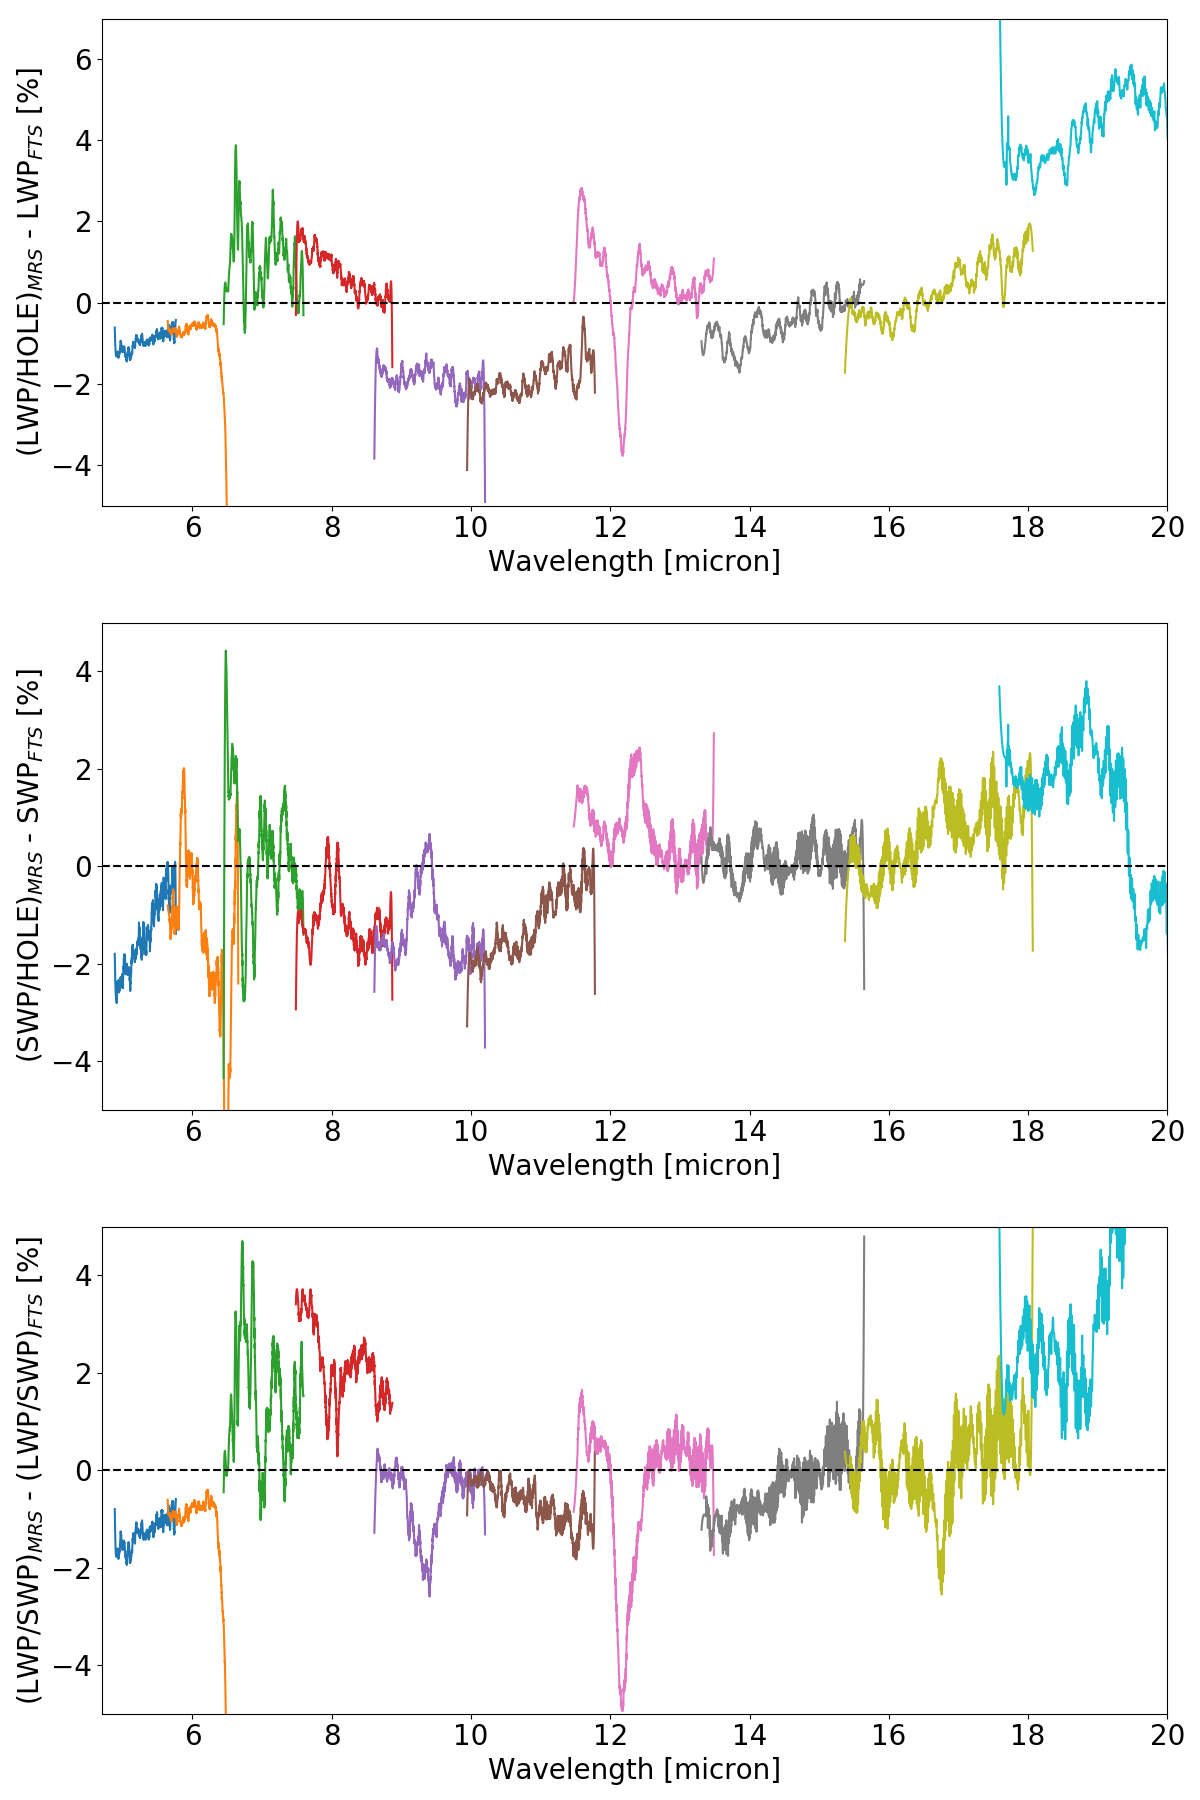

In [14]:
window_length, polyorder = 51,3

fig,axs = plt.subplots(3,1,figsize=(12,18))
for band in bands:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    lambdaMap = d2cMaps['lambdaMap']
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
    sel = (lambdaMap[ypos,xpos] !=0) & (~isnan(EXT_CAL_pixMap[band][ypos,xpos]) )
    axs[0].plot(lambdaMap[ypos,xpos][sel],savgol_filter( ((LWP_CAL_pixMap[band][ypos,xpos]/EXT_CAL_pixMap[band][ypos,xpos])[sel] - interp_lab_lwp(lambdaMap[ypos,xpos][sel]))*100. ,window_length, polyorder),zorder=0)
    axs[1].plot(lambdaMap[ypos,xpos][sel],savgol_filter( ((SWP_CAL_pixMap[band][ypos,xpos]/EXT_CAL_pixMap[band][ypos,xpos])[sel] - interp_lab_swp(lambdaMap[ypos,xpos][sel]))*100. ,window_length, polyorder),zorder=0)
    axs[2].plot(lambdaMap[ypos,xpos][sel],savgol_filter( ((LWP_CAL_pixMap[band][ypos,xpos]/SWP_CAL_pixMap[band][ypos,xpos])[sel] - interp_lab_ratio(lambdaMap[ypos,xpos][sel]))*100. ,window_length, polyorder),zorder=0)
for plot in range(3):
    axs[plot].hlines(0,4.7,28.8,'k',linestyle='dashed',zorder=1)
    axs[plot].set_xlim(4.7,20)
    axs[plot].set_xlabel('Wavelength [micron]')
axs[0].set_ylim(-5,7)
axs[1].set_ylim(-5,5)
axs[2].set_ylim(-5,5)
axs[0].set_ylabel(r'(LWP/HOLE)$_{MRS}$ - LWP$_{FTS}$ [%]')
axs[1].set_ylabel(r'(SWP/HOLE)$_{MRS}$ - SWP$_{FTS}$ [%]')
axs[2].set_ylabel(r'(LWP/SWP)$_{MRS}$ - (LWP/SWP)$_{FTS}$ [%]')
plt.tight_layout()

Below we show the MRS tolerance to spectral leak. The spectral leak criterion is defined according to a flat spectrum.

<IPython.core.display.Javascript object>


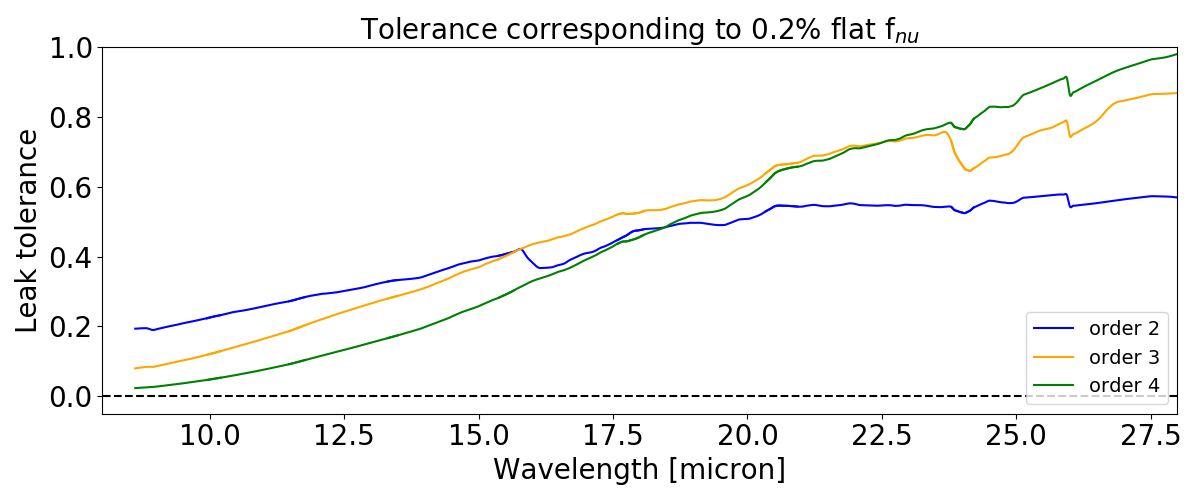

In [16]:
t_flat = 0.2

tabLSky = fits.open(MTSDir+ "MTSEquivalentLsky800K.fits" )[1]
interp_Lsky = scp_interpolate.interp1d(tabLSky.data["wave"], tabLSky.data["L_sky"], kind='cubic')

plt.figure(figsize=(12,5))
for band in bands[4:]:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    lambdaMap = d2cMaps['lambdaMap']
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
    sel = (lambdaMap[ypos,xpos] !=0) & (~isnan(EXT_CAL_pixMap[band][ypos,xpos]) )
    t_800K_n2 = t_flat * (interp_Lsky(lambdaMap[ypos,xpos][sel]/2.) / interp_Lsky(lambdaMap[ypos,xpos][sel]))
    t_800K_n3 = t_flat * (interp_Lsky(lambdaMap[ypos,xpos][sel]/3.) / interp_Lsky(lambdaMap[ypos,xpos][sel]))
    t_800K_n4 = t_flat * (interp_Lsky(lambdaMap[ypos,xpos][sel]/4.) / interp_Lsky(lambdaMap[ypos,xpos][sel]))
    plt.plot(lambdaMap[ypos,xpos][sel],t_800K_n2,'b')
    plt.plot(lambdaMap[ypos,xpos][sel],t_800K_n3,'orange')
    plt.plot(lambdaMap[ypos,xpos][sel],t_800K_n4,'g')
plt.hlines(0,4.7,28.8,'k',linestyle='dashed',zorder=1)
plt.xlim(8,28)
plt.ylim(-0.05,1)
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'Leak tolerance')
legend_elements = [Line2D([0],[0],color='b',label='order 2'),
                   Line2D([0],[0],color='orange',label='order 3'),
                   Line2D([0],[0],color='g',label='order 4')]
plt.legend(handles=legend_elements,loc='lower right')
plt.title(r'Tolerance corresponding to 0.2% flat f$_{nu}$')
plt.tight_layout()

### Remarks:
* The dominant leak shifts from order 2 below 15.75microns to order 3 between 15.75microns and 22.44micron, to order 4 above 22.44microns.
  
Let us see how the above translates to the case of the MRS (LWP/SWP) comparison. For more information see MIRI-TR-00012-KUL written by Dr. Bart Vandenbussche.

<IPython.core.display.Javascript object>


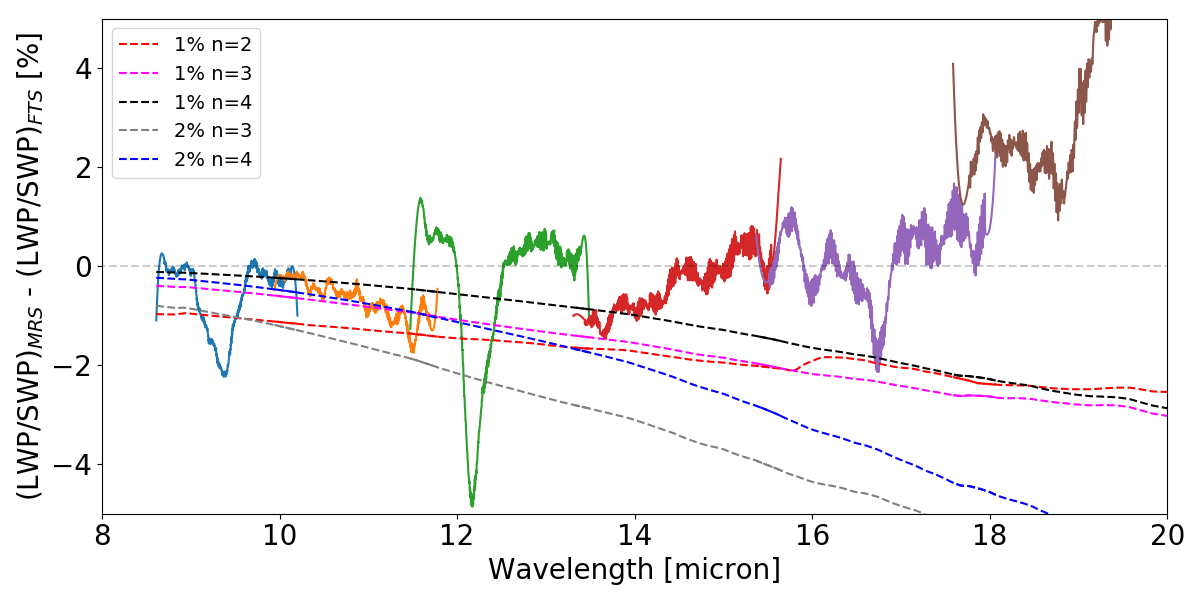

In [32]:
t_flat_1,t_flat_2 = 1.,2. # percent
window_length, polyorder = 101,3

plt.figure(figsize=(12,6))
for band in bands[4:]:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    lambdaMap = d2cMaps['lambdaMap']
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
    sel = (lambdaMap[ypos,xpos] !=0) & (~isnan(EXT_CAL_pixMap[band][ypos,xpos]) )
    plt.plot(lambdaMap[ypos,xpos][sel],savgol_filter( ((LWP_CAL_pixMap[band][ypos,xpos]/SWP_CAL_pixMap[band][ypos,xpos])[sel] - interp_lab_ratio(lambdaMap[ypos,xpos][sel]))*100. ,window_length, polyorder),zorder=0)

    t_800K_n2 = t_flat_1 * (interp_Lsky(lambdaMap[ypos,xpos][sel]/2.) / interp_Lsky(lambdaMap[ypos,xpos][sel]))
    t_800K_n3 = t_flat_1 * (interp_Lsky(lambdaMap[ypos,xpos][sel]/3.) / interp_Lsky(lambdaMap[ypos,xpos][sel]))
    t_800K_n4 = t_flat_1 * (interp_Lsky(lambdaMap[ypos,xpos][sel]/4.) / interp_Lsky(lambdaMap[ypos,xpos][sel]))
    plt.plot(lambdaMap[ypos,xpos][sel],-t_800K_n2,'r',linestyle='dashed')
    plt.plot(lambdaMap[ypos,xpos][sel],-t_800K_n3,'magenta',linestyle='dashed')
    plt.plot(lambdaMap[ypos,xpos][sel],-t_800K_n4,'k',linestyle='dashed')
    
    t_800K_n3 = t_flat_2 * (interp_Lsky(lambdaMap[ypos,xpos][sel]/3.) / interp_Lsky(lambdaMap[ypos,xpos][sel]))
    t_800K_n4 = t_flat_2 * (interp_Lsky(lambdaMap[ypos,xpos][sel]/4.) / interp_Lsky(lambdaMap[ypos,xpos][sel]))
    plt.plot(lambdaMap[ypos,xpos][sel],-t_800K_n3,'gray',linestyle='dashed')
    plt.plot(lambdaMap[ypos,xpos][sel],-t_800K_n4,'b',linestyle='dashed')
plt.hlines(0,4.7,28.8,'k',linestyle='dashed',alpha=0.2,zorder=1)
plt.xlim(8,20)
plt.ylim(-5,5)
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'(LWP/SWP)$_{MRS}$ - (LWP/SWP)$_{FTS}$ [%]')
legend_elements = [Line2D([0],[0],color='r',linestyle='dashed',label='1% n=2'),
                   Line2D([0],[0],color='magenta',linestyle='dashed',label='1% n=3'),
                   Line2D([0],[0],color='k',linestyle='dashed',label='1% n=4'),
                   Line2D([0],[0],color='gray',linestyle='dashed',label='2% n=3'),
                   Line2D([0],[0],color='b',linestyle='dashed',label='2% n=4')]
plt.legend(handles=legend_elements,loc='upper left')
plt.tight_layout()